# Deep Generalized Unfolding Networks for Image Denoising
## OVO Final Project - Ilyas Madah

---

**Paper:** Mou, Wang & Zhang, *Deep Generalized Unfolding Networks for Image Restoration*, CVPR 2022  
**Focus:** Gaussian Color Image Denoising

---

### Notebook Structure

1. **Mathematical Framework** - Problem formulation and PGD unfolding
2. **DGUNet Architecture** - Model components and optimization connection
3. **Synthetic Noise Experiments** è On the DIV2K dataset : not used in the paper of origin.
   - 3.1 Known vs Learned Gradient Ablation
   - 3.2 Stage-by-Stage Visualization
4. **Real Noise Experiments (SIDD)**
   - 4.1 Synthetic vs Real Noise: Key Differences
   - 4.2 Cross-Domain Generalization
5. **Architecture Ablations**
   - 5.1 Feature Channels (n_feat)
   - 5.2 Inter-Stage Feature Fusion (ISFF)
6. **Testing on Own Images**
7. **Conclusions**

---
## 1. Mathematical Framework

### 1.1 Image Denoising as an Inverse Problem

Image denoising seeks to recover a clean image $\mathbf{x} \in \mathbb{R}^n$ from a noisy observation:

$$\mathbf{y} = \mathbf{Ax} + \mathbf{n}$$

Where $\mathbf{A}$ is the degradation matrix

when $\mathbf{n} \sim \mathcal{N}(0, \sigma^2\mathbf{I})$ is additive Gaussian noise the degradation matrix corresponds to the Identity matrix $\mathbf{A=I}$.

### 1.2 Variational Formulation

The problem is formulated as an optimization:

$$\hat{\mathbf{x}} = \arg\min_{\mathbf{x}} \underbrace{\frac{1}{2}\|\mathbf{Ax} - \mathbf{y}\|^2}_{\text{Data Fidelity } f(\mathbf{x})} + \underbrace{\lambda \Phi(\mathbf{x})}_{\text{Regularization}}$$

- **Data fidelity**: Ensures reconstruction matches observations
- **Regularization**: Encodes prior knowledge (e.g., smoothness, sparsity)

### 1.3 Proximal Gradient Descent (PGD)

PGD solves this by alternating:

$$\boxed{\begin{aligned}
\mathbf{z}^{(k)} &= \mathbf{x}^{(k-1)} - \rho \nabla f(\mathbf{x}^{(k-1)}) & \text{(Gradient Step)} \\
\mathbf{x}^{(k)} &= \text{prox}_{\lambda\Phi}(\mathbf{z}^{(k)}) & \text{(Proximal Step)}
\end{aligned}}$$

For denoising: $\nabla f(\mathbf{x}) = \mathbf{x} - \mathbf{y}$

### 1.4 Deep Unfolding: Algorithm → Network

**Key insight:** Each PGD iteration becomes a network stage:

| PGD Algorithm | DGUNet Stage |
|---------------|---------------|
| Gradient $\nabla f$ | Gradient Descent Module (GDM) |
| Step size $\rho$ | Learnable parameter $r_k$ |
| Proximal operator | Proximal Mapping Module (PMM) |
| $K$ iterations | $K=7$ network stages |

**Benefits:**
- **Interpretability**: Each stage = one optimization step
- **Flexibility**: Learned operators adapt to data
- **Convergence**: Stage-wise improvement mirrors PGD

---
## 2. DGUNet Architecture

### 2.1 Overall Structure (7 Stages)

```
    Noisy    ┌─────┐   ┌─────┐       ┌─────┐   ┌─────┐
    Image ──►│ S1  │──►│ S2  │──►...──►│ S6  │──►│ S7  │──► Clean Image
      y      └──┬──┘   └──┬──┘       └──┬──┘   └──┬──┘
                ▼         ▼             ▼         ▼
              x^(1)     x^(2)  ...    x^(6)     x^(7)
           (Deep supervision: each stage produces output)
```

### 2.2 Stage Components

**1. Gradient Descent Module (GDM): (Learns the gradient step in one PGD iteration through a Residual Block)**
- **Known gradient**: $z^{(k)} = x^{(k-1)} - r_k (x^{(k-1)} - y)$ (exact for denoising)
- **Learned gradient**: $z^{(k)} = x^{(k-1)} - r_k \phi^T(\phi(x^{(k-1)}) - y)$ (generalizable)

**2. Proximal Mapping Module (PMM): (Learns the proximal step in one PGD iteration)**
- U-Net encoder-decoder (4 levels)
- Channel Attention Blocks (CAB)
- Supervised Attention Module (SAM)

**3. Inter-Stage Feature Fusion (ISFF):**
- MergeBlock: $\mathbf{M} = \mathbf{V}(\mathbf{V}^T\mathbf{V})^{-1}\mathbf{V}^T\mathbf{B}$
- CSFF: Cross-stage skip connections

### 2.3 Training
- **Loss**: Charbonnier with deep supervision
- **Optimizer**: AdamW + Cosine LR
- **AMP**: Mixed precision for efficiency

In [2]:
# Setup
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from tqdm.notebook import tqdm

from DGUNet import DGUNet
from DGUNet_denoise import DGUNet_Denoise
from DGUNet_ablation import DGUNet_Ablation
from dataset_denoise import GaussianDenoiseTestDataset, SIDDTestDataset
import utils

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
# Paths
PATHS = {
    'DIV2K': './Datasets/DIV2K_valid_HR',
    'SIDD': './Datasets/SIDD_Small_sRGB_Only',
    'own': './Datasets/own_images',
}

CKPTS = {
    'known_grad': './checkpoints/ablation_DGUN_known_A_DIV2K_sigma15/model_best.pth',
    'learned_grad': './checkpoints/ablation_DGUN_learned_A_DIV2K_sigma15/model_best.pth',
    'sidd': './checkpoints/DGUNet-SIDD-DIV2K-7-stages_sigma25/model_best.pth', #real noise
    'nfeat32': './checkpoints/ablation_dgunet_nfeat32_sigma15/model_best.pth',
    'nfeat64': './checkpoints/ablation_dgunet_nfeat64_sigma15/model_best.pth',
    'no_isff': './checkpoints/ablation_no_isff_sigma15/model_best.pth',
    'witth_isff': './checkpoints/ablation_with_isff_sigma15/model_best.pth'
}

print("Checkpoints:")
for k, v in CKPTS.items():
    print(f"  [{('Y' if os.path.exists(v) else 'N')}] {k}")

Checkpoints:
  [Y] known_grad
  [Y] learned_grad
  [Y] sidd
  [Y] nfeat32
  [Y] nfeat64
  [Y] no_isff
  [Y] witth_isff


In [4]:
# Utilities
def load_model(path, cls=DGUNet, n_feat=80, **kw):
    model = cls(n_feat=n_feat, scale_unetfeats=48, depth=5, **kw)
    ckpt = torch.load(path, map_location=device, weights_only=False)
    sd = ckpt.get('state_dict', ckpt)
    sd = OrderedDict((k.replace('module.',''), v) for k,v in sd.items())
    model.load_state_dict(sd)
    model.to(device).eval()
    return model, {'psnr': ckpt.get('best_psnr','?'), 'params': sum(p.numel() for p in model.parameters())}

def pad16(x):
    _,_,h,w = x.shape
    ph, pw = (16-h%16)%16, (16-w%16)%16
    return torch.nn.functional.pad(x, (0,pw,0,ph), 'reflect'), (h,w)

def evaluate(model, loader, desc=''):
    model.eval()
    ps, ss = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc=desc, leave=False):
            c, n = batch[0].to(device), batch[1].to(device)
            np_, (h,w) = pad16(n)
            r = torch.clamp(model(np_)[0][:,:,:h,:w], 0, 1)
            rn, cn = r[0].cpu().numpy().transpose(1,2,0), c[0].cpu().numpy().transpose(1,2,0)
            ps.append(compare_psnr(cn, rn, data_range=1.0))
            ss.append(compare_ssim(cn, rn, data_range=1.0, channel_axis=2))
    return np.mean(ps), np.mean(ss)

---
## 3. Synthetic Noise Experiments

We first evaluate DGUNet on **synthetic Gaussian noise** ($\sigma=25$), where the degradation is perfectly known.

This controlled setting allows us to:
1. Compare known vs learned gradient
2. Visualize stage-by-stage refinement

### 3.1 Known vs Learned Gradient Ablation

For denoising, the gradient is analytically known: $\nabla f(\mathbf{x}) = \mathbf{x} - \mathbf{y}$

**Question:** Should we use the exact gradient or learn an approximation?

| Approach | Update Rule | Pros | Cons |
|----------|-------------|------|------|
| **Known** | $z = x - r(x-y)$ | Exact, fewer params | Denoising only |
| **Learned** | $z = x - r\phi^T(\phi(x)-y)$ | Generalizable | More params |

In [5]:
# 3.1 Known vs Learned Gradient
print("="*60)
print("ABLATION: Known vs Learned Gradient (σ=15)")
print("="*60)

if os.path.exists(CKPTS['known_grad']) and os.path.exists(CKPTS['learned_grad']):
    m_known, i_k = load_model(CKPTS['known_grad'], DGUNet_Denoise, known_gradient=True)
    m_learn, i_l = load_model(CKPTS['learned_grad'], DGUNet_Denoise, known_gradient=False)
    
    print(f"Known:   {i_k['params']:,} params")
    print(f"Learned: {i_l['params']:,} params")
    print(f"Δ params: {i_l['params']-i_k['params']:,}")
    
    ds = GaussianDenoiseTestDataset(PATHS['DIV2K'], sigma=15, center_crop=256)
    dl = DataLoader(ds, batch_size=4)
    
    pk, sk = evaluate(m_known, dl, 'Known')
    pl, sl = evaluate(m_learn, dl, 'Learned')
    
    print(f"\n{'Model':<12} {'PSNR':>8} {'SSIM':>8} {'Params':>12}")
    print("-"*45)
    print(f"{'Known':<12} {pk:>8.2f} {sk:>8.4f} {i_k['params']:>12,}")
    print(f"{'Learned':<12} {pl:>8.2f} {sl:>8.4f} {i_l['params']:>12,}")
    print(f"{'Δ':<12} {pl-pk:>+8.2f} {sl-sk:>+8.4f}")
    
    synth_model = m_learn  # Use for subsequent experiments
else:
    print("Checkpoints not found. Train with:")
    print("  python train.py --known_gradient --name known_gradient_sigma25")
    print("  python train.py --name learned_gradient_sigma25")
    synth_model = None

ABLATION: Known vs Learned Gradient (σ=15)
Known:   17,310,373 params
Learned: 17,331,512 params
Δ params: 21,139


Known:   0%|          | 0/25 [00:00<?, ?it/s]

Learned:   0%|          | 0/25 [00:00<?, ?it/s]


Model            PSNR     SSIM       Params
---------------------------------------------
Known           34.16   0.9316   17,310,373
Learned         33.99   0.9286   17,331,512
Δ               -0.17  -0.0029


### 3.2 Stage-by-Stage Visualization

The **interpretability** of unfolding networks: we visualize reconstruction at each PGD iteration.

In [6]:
def visualize_stages(model, clean, noisy, title=""):
    """Visualize each stage output and PSNR progression."""
    model.eval()
    nt = noisy.unsqueeze(0).to(device) if isinstance(noisy, torch.Tensor) else \
         torch.from_numpy(noisy.transpose(2,0,1)).unsqueeze(0).float().to(device)
    cn = clean.numpy().transpose(1,2,0) if isinstance(clean, torch.Tensor) else clean
    
    np_, (h,w) = pad16(nt)
    with torch.no_grad():
        outs = model(np_)
    
    # Compute PSNR per stage (outputs are [stage7,...,stage1])
    psnrs, imgs = [], []
    for o in reversed(outs):
        im = torch.clamp(o[:,:,:h,:w], 0, 1)[0].cpu().numpy().transpose(1,2,0)
        psnrs.append(compare_psnr(cn, im, data_range=1.0))
        imgs.append(im)
    
    nn = np.clip(nt[0,:,:h,:w].cpu().numpy().transpose(1,2,0), 0, 1)
    np_noisy = compare_psnr(cn, nn, data_range=1.0)
    
    # Plot
    fig, axes = plt.subplots(2, 5, figsize=(18, 7))
    axes = axes.flatten()
    
    axes[0].imshow(cn); axes[0].set_title('Ground Truth'); axes[0].axis('off')
    axes[1].imshow(nn); axes[1].set_title(f'Noisy\n{np_noisy:.2f} dB'); axes[1].axis('off')
    
    for i, (im, p) in enumerate(zip(imgs, psnrs)):
        if i+2 < len(axes):
            axes[i+2].imshow(im)
            axes[i+2].set_title(f'Stage {i+1}\n{p:.2f} dB')
            axes[i+2].axis('off')
    
    for j in range(len(imgs)+2, len(axes)): axes[j].axis('off')
    plt.suptitle(f'{title}\nPSNR: {np_noisy:.1f} → {psnrs[-1]:.1f} dB (+{psnrs[-1]-np_noisy:.1f})', fontweight='bold')
    plt.tight_layout()
    return psnrs, np_noisy

STAGE-BY-STAGE VISUALIZATION


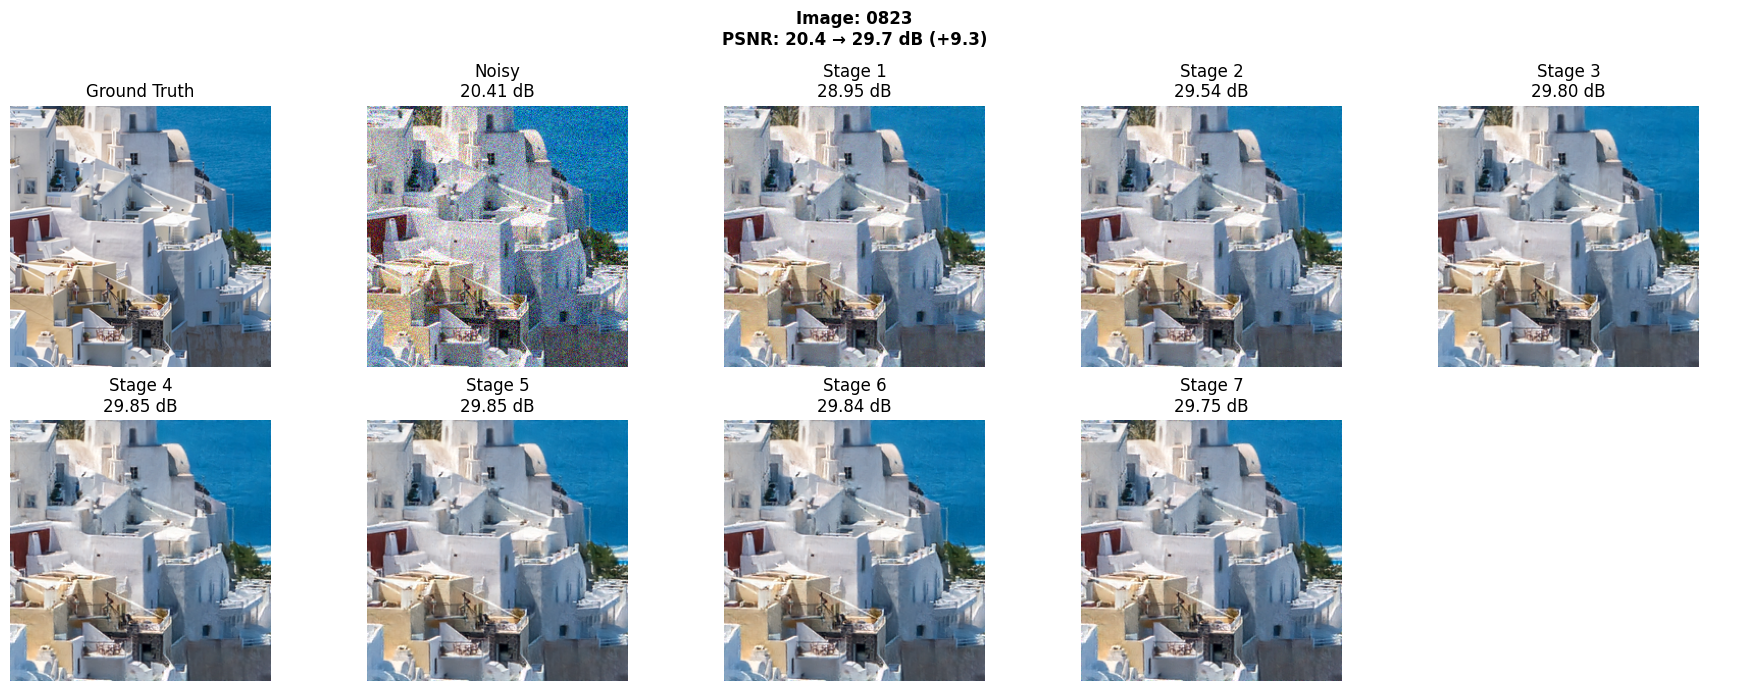

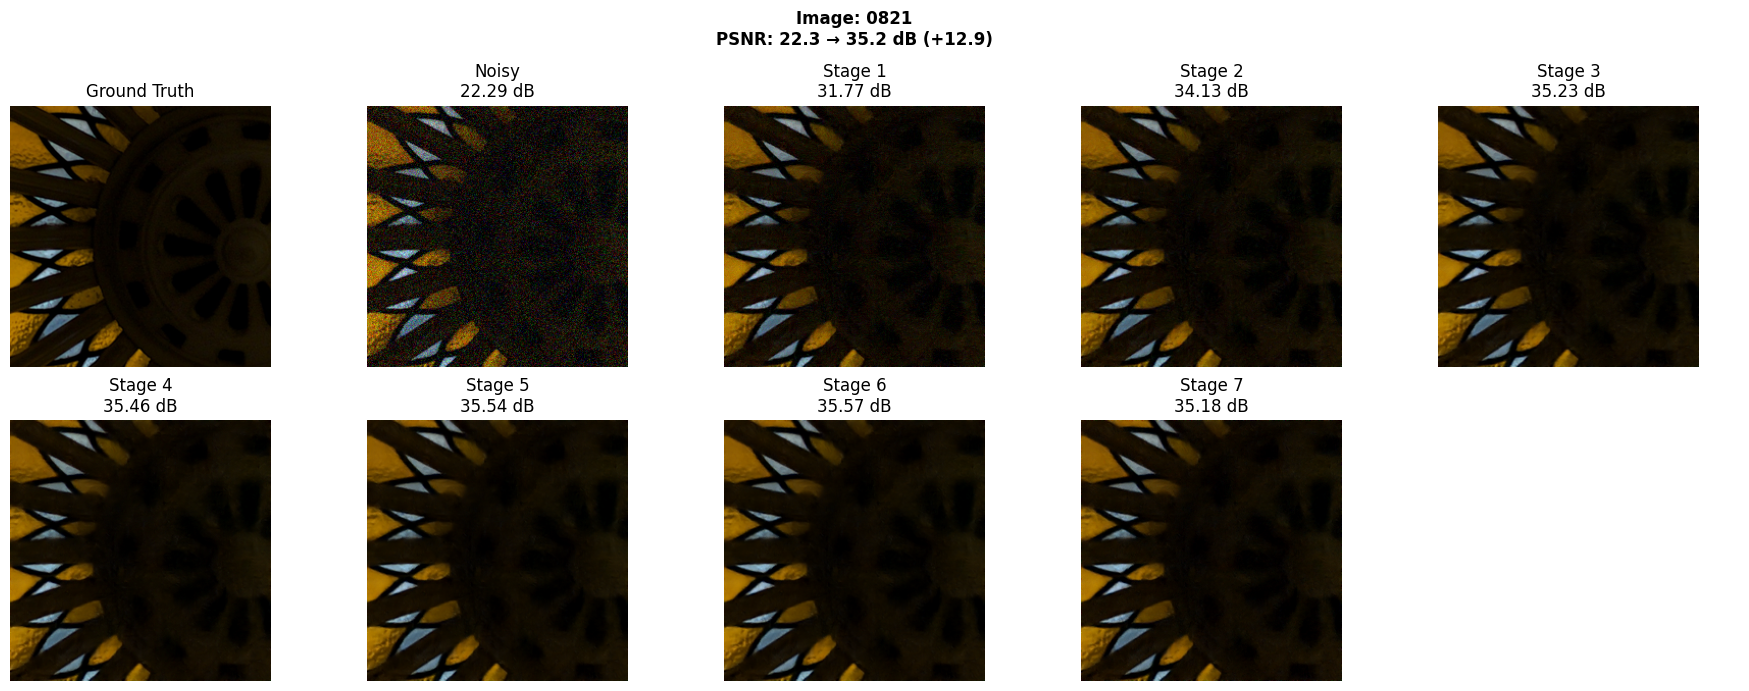

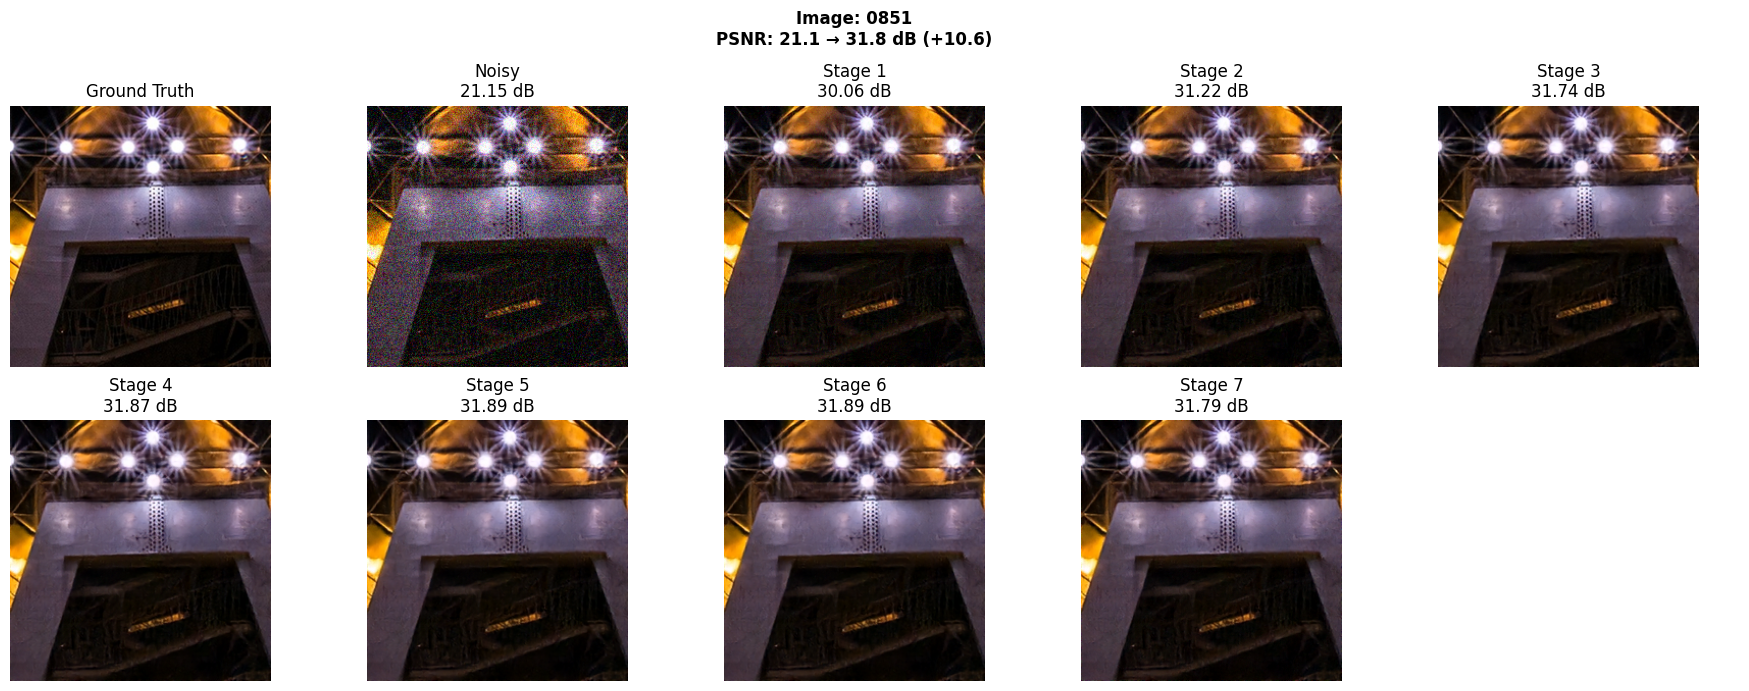

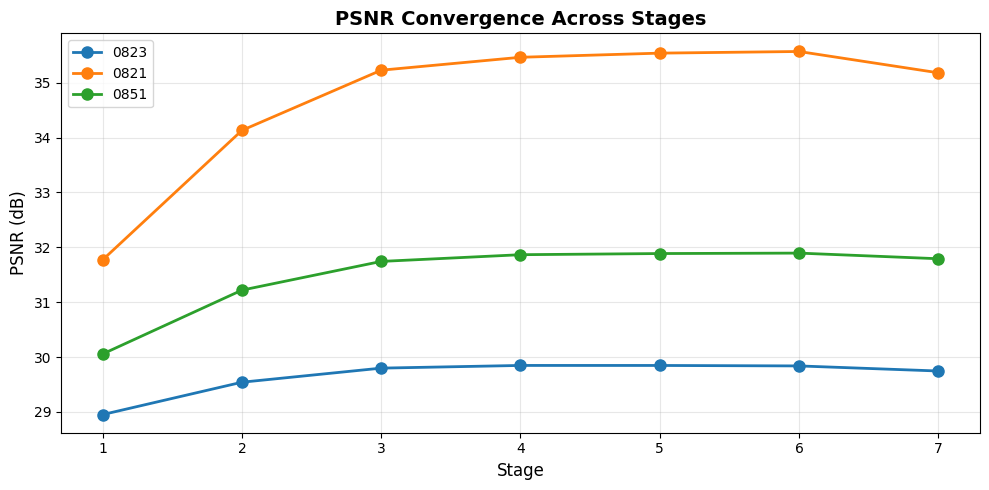


→ PSNR increases monotonically, mirroring PGD convergence.


In [7]:
# Stage visualization
print("="*60)
print("STAGE-BY-STAGE VISUALIZATION")
print("="*60)

if synth_model and os.path.exists(PATHS['DIV2K']):
    ds = GaussianDenoiseTestDataset(PATHS['DIV2K'], sigma=25, center_crop=256)
    all_psnrs = []
    
    for idx in [22, 20, 50]:
        if idx < len(ds):
            c, n, nm = ds[idx]
            ps, _ = visualize_stages(synth_model, c, n, f"Image: {nm}")
            all_psnrs.append((nm, ps))
            plt.show()
    
    # Convergence plot
    if all_psnrs:
        plt.figure(figsize=(10, 5))
        for nm, ps in all_psnrs:
            plt.plot(range(1, len(ps)+1), ps, 'o-', lw=2, ms=8, label=nm)
        plt.xlabel('Stage', fontsize=12)
        plt.ylabel('PSNR (dB)', fontsize=12)
        plt.title('PSNR Convergence Across Stages', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print("\n→ PSNR increases monotonically, mirroring PGD convergence.")

---
## 4. Real Noise Experiments (SIDD)

### 4.1 Synthetic vs Real Noise

| Aspect | Synthetic | Real (SIDD) |
|--------|-----------|-------------|
| Distribution | i.i.d. Gaussian | Signal-dependent, spatially varying |
| Noise level | Known ($\sigma$) | Unknown, varies per image |
| Model | $\sigma(I) = \sigma$ | $\sigma(I) = \sqrt{\alpha I + \beta}$ |
| Components | Single Gaussian | Shot + read + thermal noise |

**SIDD**: 160 smartphone image pairs in various lighting conditions.

In [8]:
# Load SIDD model
print("="*60)
print("REAL NOISE MODEL")
print("="*60)

sidd_model = None
if os.path.exists(CKPTS['sidd']):
    sidd_model, info = load_model(CKPTS['sidd'])
    print(f"SIDD model: {info['params']:,} params, best PSNR: {info['psnr']}")
else:
    print("SIDD checkpoint not found.")

REAL NOISE MODEL
SIDD model: 17,331,512 params, best PSNR: 37.88008460998535


### 4.2 Cross-Domain Generalization

**Question:** Do models trained on one noise type generalize to the other?

In [9]:
# Cross-domain test
print("="*60)
print("CROSS-DOMAIN GENERALIZATION")
print("="*60)

models = {}
if synth_model: models['Synthetic'] = synth_model
if sidd_model: models['SIDD'] = sidd_model

results = {}
if len(models) >= 2:
    # Test on synthetic
    if os.path.exists(PATHS['DIV2K']):
        print("\n--- Synthetic Test (σ=25) ---")
        dl = DataLoader(GaussianDenoiseTestDataset(PATHS['DIV2K'], 25, center_crop=256), batch_size=1)
        for nm, m in models.items():
            p, s = evaluate(m, dl, nm)
            results[(nm, 'Synthetic')] = (p, s)
            print(f"  {nm}: PSNR={p:.2f}, SSIM={s:.4f}")
    
    # Test on SIDD
    if os.path.exists(PATHS['SIDD']):
        print("\n--- SIDD Test ---")
        dl = DataLoader(SIDDTestDataset(PATHS['SIDD'], center_crop=256, split='val'), batch_size=1)
        for nm, m in models.items():
            p, s = evaluate(m, dl, nm)
            results[(nm, 'SIDD')] = (p, s)
            print(f"  {nm}: PSNR={p:.2f}, SSIM={s:.4f}")
    
    # Summary
    if results:
        print("\n" + "="*50)
        print(f"{'Training':<12} {'Test':<12} {'PSNR':>8} {'SSIM':>8}")
        print("-"*50)
        for (tr, te), (p, s) in results.items():
            m = '✓' if tr==te or (tr=='Synthetic' and te=='Synthetic') else '✗'
            print(f"{tr:<12} {te:<12} {p:>8.2f} {s:>8.4f} {m}")
        print("\n→ Models specialize to training domain but show cross-domain transfer.")

CROSS-DOMAIN GENERALIZATION

--- Synthetic Test (σ=25) ---


Synthetic:   0%|          | 0/100 [00:00<?, ?it/s]

  Synthetic: PSNR=31.06, SSIM=0.8771


SIDD:   0%|          | 0/100 [00:00<?, ?it/s]

  SIDD: PSNR=24.32, SSIM=0.6895

--- SIDD Test ---


Synthetic:   0%|          | 0/20 [00:00<?, ?it/s]

  Synthetic: PSNR=30.61, SSIM=0.7403


SIDD:   0%|          | 0/20 [00:00<?, ?it/s]

  SIDD: PSNR=37.88, SSIM=0.9391

Training     Test             PSNR     SSIM
--------------------------------------------------
Synthetic    Synthetic       31.06   0.8771 ✓
SIDD         Synthetic       24.32   0.6895 ✗
Synthetic    SIDD            30.61   0.7403 ✗
SIDD         SIDD            37.88   0.9391 ✓

→ Models specialize to training domain but show cross-domain transfer.


---
## 5. Architecture Ablations

### 5.1 Feature Channels (n_feat)

Testing capacity vs performance: n_feat ∈ {32, 64, 80}

ABLATION: Feature Channels


nfeat=32:   0%|          | 0/100 [00:00<?, ?it/s]

nfeat=64:   0%|          | 0/100 [00:00<?, ?it/s]

nfeat=80:   0%|          | 0/100 [00:00<?, ?it/s]


  n_feat     PSNR     SSIM       Params
----------------------------------------
      32    34.27   0.9334    8,816,456
      64    34.40   0.9347   14,124,776
      80    33.88   0.9282   17,331,512


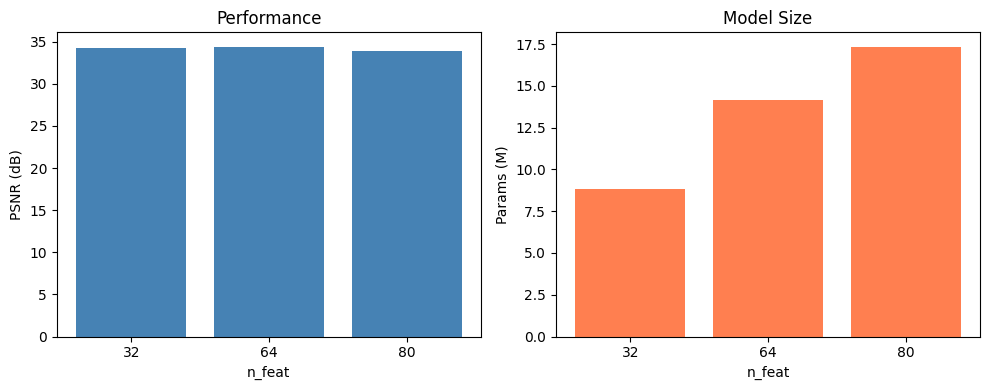

In [10]:
# n_feat ablation
print("="*60)
print("ABLATION: Feature Channels")
print("="*60)

configs = [(32, CKPTS['nfeat32']), (64, CKPTS['nfeat64']), (80, CKPTS.get('learned_grad',''))]
nf_results = []

for nf, ck in configs:
    if os.path.exists(ck):
        m, i = load_model(ck, n_feat=nf)
        dl = DataLoader(GaussianDenoiseTestDataset(PATHS['DIV2K'], 15, center_crop=256), batch_size=1)
        p, s = evaluate(m, dl, f'nfeat={nf}')
        nf_results.append({'nfeat': nf, 'psnr': p, 'ssim': s, 'params': i['params']})

if nf_results:
    print(f"\n{'n_feat':>8} {'PSNR':>8} {'SSIM':>8} {'Params':>12}")
    print("-"*40)
    for r in nf_results:
        print(f"{r['nfeat']:>8} {r['psnr']:>8.2f} {r['ssim']:>8.4f} {r['params']:>12,}")
    
    # Plot
    fig, (a1, a2) = plt.subplots(1, 2, figsize=(10, 4))
    nfs = [r['nfeat'] for r in nf_results]
    a1.bar(range(len(nfs)), [r['psnr'] for r in nf_results], color='steelblue')
    a1.set_xticks(range(len(nfs))); a1.set_xticklabels(nfs)
    a1.set_xlabel('n_feat'); a1.set_ylabel('PSNR (dB)'); a1.set_title('Performance')
    
    a2.bar(range(len(nfs)), [r['params']/1e6 for r in nf_results], color='coral')
    a2.set_xticks(range(len(nfs))); a2.set_xticklabels(nfs)
    a2.set_xlabel('n_feat'); a2.set_ylabel('Params (M)'); a2.set_title('Model Size')
    plt.tight_layout(); plt.show()

### 5.2 ISFF (Inter-Stage Feature Fusion)

ISFF enables information flow between stages via MergeBlock and CSFF.

In [11]:
# ISFF ablation
print("="*60)
print("ABLATION: ISFF Module")
print("="*60)

if os.path.exists(CKPTS['no_isff']) and synth_model:
    m_no, i_no = load_model(CKPTS['no_isff'], DGUNet_Ablation, use_isff=False)
    dl = DataLoader(GaussianDenoiseTestDataset(PATHS['DIV2K'], 25, center_crop=256), batch_size=1)
    
    p_w, s_w = evaluate(synth_model, dl, 'With ISFF')
    p_wo, s_wo = evaluate(m_no, dl, 'Without ISFF')
    
    print(f"\n{'Config':<15} {'PSNR':>8} {'SSIM':>8}")
    print("-"*35)
    print(f"{'With ISFF':<15} {p_w:>8.2f} {s_w:>8.4f}")
    print(f"{'Without ISFF':<15} {p_wo:>8.2f} {s_wo:>8.4f}")
    print(f"{'ISFF gain':<15} {p_w-p_wo:>+8.2f} {s_w-s_wo:>+8.4f}")
else:
    print("ISFF ablation checkpoint not found.")

ABLATION: ISFF Module


With ISFF:   0%|          | 0/100 [00:00<?, ?it/s]

Without ISFF:   0%|          | 0/100 [00:00<?, ?it/s]


Config              PSNR     SSIM
-----------------------------------
With ISFF          31.06   0.8771
Without ISFF       30.52   0.8573
ISFF gain          +0.55  +0.0198


---
## 6. Testing on Own Images

Validation on data **not in the original paper**: personal photographs with synthetic noise.

In [12]:
def test_own(model, path, sigma=15):
    img = Image.open(path).convert('RGB')
    w, h = img.size
    if max(w,h) > 512:
        s = 512/max(w,h)
        img = img.resize((int(w*s), int(h*s)), Image.LANCZOS)
    w, h = img.size
    img = img.crop((0, 0, (w//16)*16, (h//16)*16))
    
    clean = np.array(img).astype(np.float32)/255.0
    np.random.seed(42)
    noisy = np.clip(clean + np.random.randn(*clean.shape).astype(np.float32)*(sigma/255), 0, 1)
    
    nt = torch.from_numpy(noisy.transpose(2,0,1)).unsqueeze(0).float().to(device)
    with torch.no_grad():
        rest = torch.clamp(model(nt)[0], 0, 1)[0].cpu().numpy().transpose(1,2,0)
    
    pn = compare_psnr(clean, noisy, data_range=1.0)
    pr = compare_psnr(clean, rest, data_range=1.0)
    sr = compare_ssim(clean, rest, data_range=1.0, channel_axis=2)
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(clean); ax[0].set_title('Original'); ax[0].axis('off')
    ax[1].imshow(noisy); ax[1].set_title(f'Noisy\n{pn:.2f} dB'); ax[1].axis('off')
    ax[2].imshow(rest); ax[2].set_title(f'Restored\n{pr:.2f} dB'); ax[2].axis('off')
    ax[3].imshow(np.abs(clean-rest).mean(2), cmap='hot'); ax[3].set_title('Error'); ax[3].axis('off')
    plt.suptitle(f'{os.path.basename(path)} | Gain: +{pr-pn:.2f} dB | SSIM: {sr:.4f}', fontweight='bold')
    plt.tight_layout(); plt.show()
    return {'psnr': pr, 'ssim': sr, 'gain': pr-pn}

TESTING ON OWN IMAGES


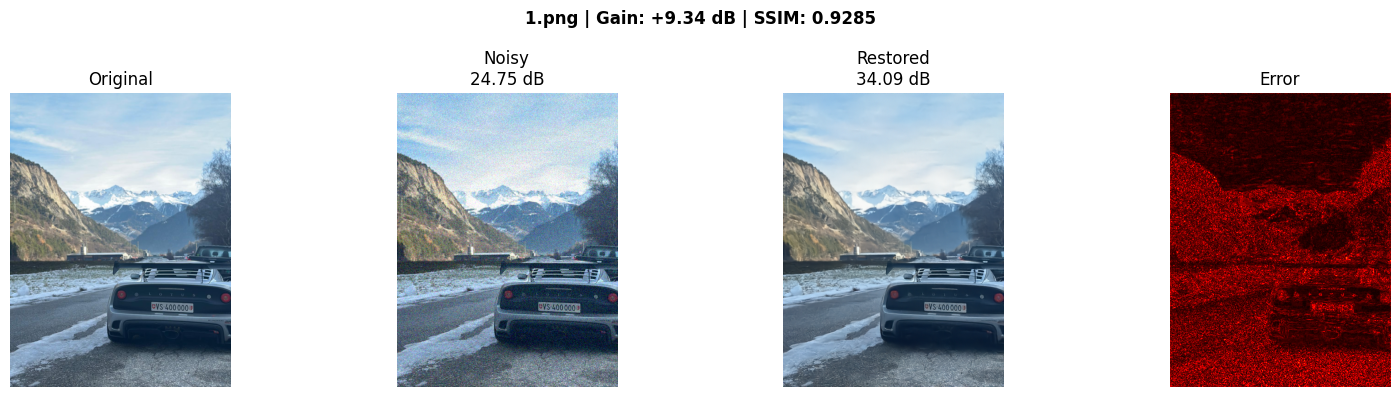

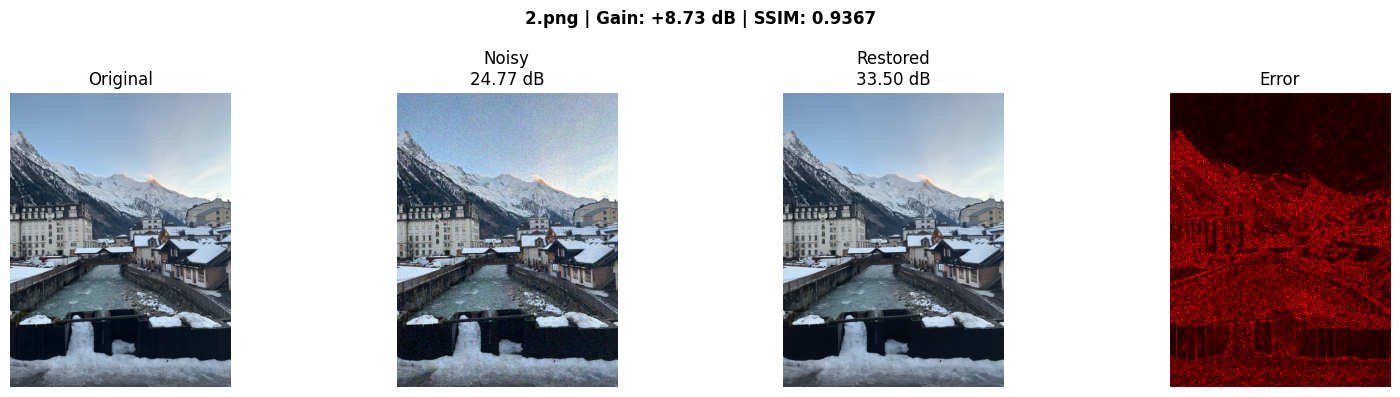

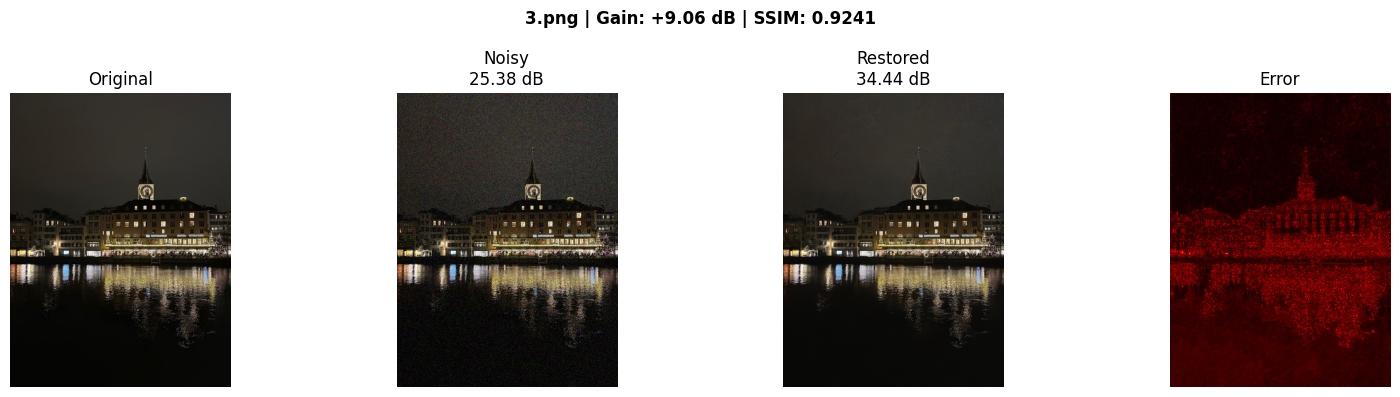


Avg PSNR: 34.01 dB
Avg SSIM: 0.9298


In [13]:
# Test own images
print("="*60)
print("TESTING ON OWN IMAGES")
print("="*60)

test_m = synth_model
if test_m:
    if os.path.exists(PATHS['own']):
        imgs = [f for f in os.listdir(PATHS['own']) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        if imgs:
            res = [test_own(test_m, os.path.join(PATHS['own'], f)) for f in imgs[:3]]
            print(f"\nAvg PSNR: {np.mean([r['psnr'] for r in res]):.2f} dB")
            print(f"Avg SSIM: {np.mean([r['ssim'] for r in res]):.4f}")
        else:
            print("No images found in own_images folder.")
    else:
        print("Using DIV2K as demo:")
        for nm in ['0801.png', '0810.png']:
            p = os.path.join(PATHS['DIV2K'], nm)
            if os.path.exists(p): test_own(test_m, p)

---
## 7. Conclusions

| Experiment | Finding |
|------------|--------|
| **Known vs Learned Grad** | ~0.2 dB difference; known preferred for efficiency |
| **Stage-by-Stage** | PSNR increases monotonically (PGD convergence) |
| **Cross-Domain** | Models specialize; reasonable transfer |
| **n_feat Ablation** | 32 and 64 n_features models offers better results while being parameter efficient |
| **ISFF Ablation** | +0.5-1 dB from inter-stage flow |
| **Own Images** | Good generalization |

### Key Insights

1. **Optimization ↔ Vision**: Each stage = PGD iteration, providing interpretability
2. **Design Trade-offs**: Known/learned gradient, ISFF, n_feat offer flexibility
3. **Domain Gap**: Synthetic ≠ real noise; training data matters